In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
from collections import defaultdict
import demes, demesdraw, matplotlib.pylab as plt
import msprime as ms

import model, slice, get_LD, plot_LD

##### Functions

In [11]:
def plot_iicr(iirc,T): 
    plt.plot(T, iirc)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("time ago (years)",fontsize = 14)
    plt.ylabel(r"IICR",fontsize = 14);

In [12]:
def plot_comparison(LDpop1,LDpop2,labels=["Original","Size Change"]):
    rhos = np.logspace(-2, 2, 21)
    
    # plot D2
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax.plot(rhos,LDpop1[:,0],label=labels[0])
    ax.plot(rhos,LDpop2[:,0],label=labels[1])
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"$\sigma_d^2$")
    ax.set_xlabel(r"$\rho$")

    # plot DZ
    ax2.plot(rhos,LDpop1[:,1],label=labels[0])
    ax2.plot(rhos,LDpop2[:,1],label=labels[1])
    ax2.legend()
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_ylabel(r"$\sigma_{Dz}$")
    ax2.set_xlabel(r"$\rho$")

    plt.tight_layout()
    plt.show()

In [56]:

def get_N_times_from_iicr(iicr,T):
    """
    Takes an the inverse inferred rate of coalescence and the time points and returns the times at which size changes.
    """
    previous_N = 0
    Ns = []
    times = []  
    for N,time in zip(iicr,T):
        if int(N) != int(previous_N):
            Ns.append(int(N))
            times.append(time)
            previous_N = int(N)

    return np.flip(Ns),np.flip(times)

def size_change_from_iicr(iicr,T,yaml_filename=None,plot=True,plot_filename=None,time_units="years",generation_time=29):
    """
    Takes a vector of Ns in form of iicr and T times to create a model
    """
    if time_units == "generations":
        generation_time=1

    Ns,times = get_N_times_from_iicr(iicr,T)
    
    m = demes.Builder(time_units=time_units,generation_time=generation_time)

    #current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,times):
        epoch = dict(start_size=N,end_time=time)
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph  
    

In [57]:
def run_LD_analysis_from_model(Demes_model,time_units="generations",generation_time=1):
    # Sample times at epochs
    T,_ = slice.sample_timepoints(Demes_model,anc_end_time=1e6/29)
    # Compute LD 
    model_sliced = slice.slice_timepoints(Demes_model,time_points=[0])
    model_sliced_LD = get_LD.get_LD_from_sliced_demes(model_sliced)
    # Get IIRC
    if time_units == "years":
        time_iicr=T/29
    else:
        time_iicr=T
    _, model_iicr, _ = model.get_iicr(Demes_model,pop="Merge_1",T=time_iicr)
    plot_iicr(model_iicr,T)
    
    model_sc = size_change_from_iicr(model_iicr,T,time_units=time_units,generation_time=generation_time,plot=True)
    # Slice the generated model and get LD
    model_sc_sliced = slice.slice_timepoints(model_sc,time_points=[0])
    model_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(model_sc_sliced)
    # Get signal magnitude
    x = model_sliced_LD['Merge_1'][-1] # Model
    y = model_sc_sliced_LD['Deme'][-1] # size change
    plot_comparison(x,y)
    
    return 

In [58]:
def size_change(Ns,time_period,yaml_filename=None,plot=True,plot_filename=None,time_units="years",generation_time=29):
    
    if time_units == "generations":
        generation_time=1

    m = demes.Builder(time_units=time_units,generation_time=generation_time)
    current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,time_period):
        epoch = dict(start_size=N,end_time=current_time-time)
        current_time=current_time-time
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()

    # Check demographic events
    print(epochs)
    
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph 

##### Arguments for models

In [4]:
N = 20e3
time_period = 0.1*N

##### 1. Constant population

<AxesSubplot:ylabel='time ago (generations)'>

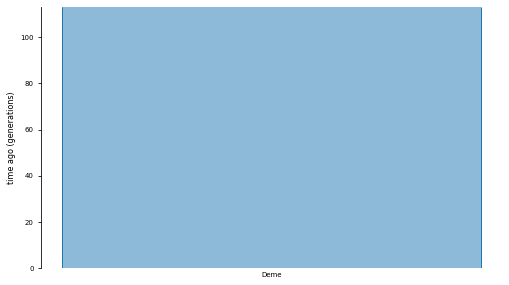

In [14]:
constant = demes.Builder()
constant.add_deme("Deme",epochs=[dict(start_size=N)])
graph = constant.resolve()
demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

In [15]:
T,times_dic = slice.sample_timepoints(graph)

In [16]:
# Compute LD 
c_sliced = slice.slice_timepoints(graph,time_points=[0])
c_sliced_LD = get_LD.get_LD_from_sliced_demes(c_sliced)

In [17]:
c_R, c_iicr, _ = model.get_iicr(graph,pop="Deme",T=T)
c_sc = model.size_change_from_iicr(c_iicr,T,time_units="generations",plot=False)

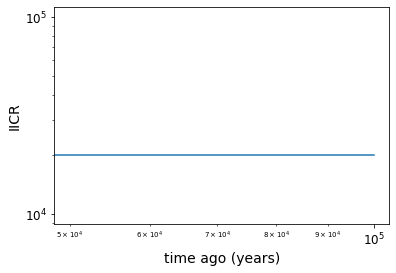

In [18]:
plot_iicr(c_iicr,T)

In [19]:
# Actually slice
c_sc_sliced = slice.slice_timepoints(c_sc,time_points=[0])
c_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(c_sc_sliced)

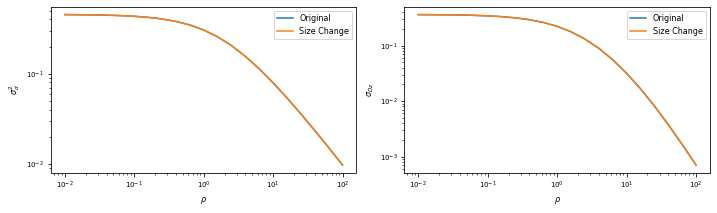

In [20]:
plot_comparison(c_sliced_LD['Deme'][-1],c_sc_sliced_LD['Deme'][-1])

##### 2. Size change - No structure

[{'start_size': 20000.0, 'end_time': 4000.0}, {'start_size': 2000.0, 'end_time': 1000.0}, {'start_size': 10000.0, 'end_time': 0.0}]


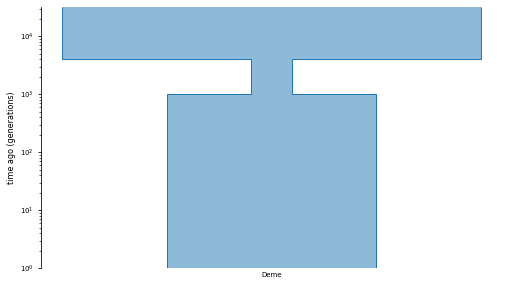

In [8]:
sc_model = size_change(Ns=[N,N/10,N/2],time_period=[time_period,time_period*1.5,time_period/2],time_units="generations")

In [9]:
# Sample times at epochs
T,times_dic = slice.sample_timepoints(sc_model)
# Compute LD 
sc_sliced = slice.slice_timepoints(sc_model,time_points=[0])
sc_sliced_LD = get_LD.get_LD_from_sliced_demes(sc_sliced)

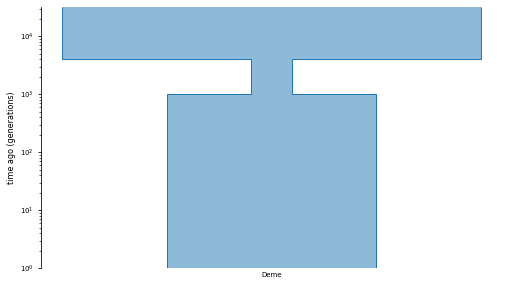

In [13]:
# Get IIRC
sc_R, sc_iicr, _ = model.get_iicr(sc_model,pop="Deme",T=T)
sc_sc = model.size_change_from_iicr(sc_iicr,T,time_units="generations",plot=True)

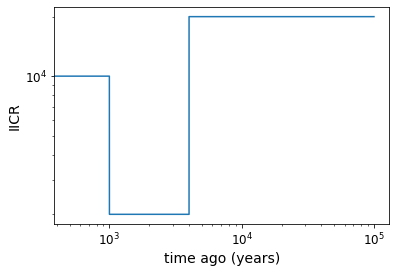

In [24]:
plot_iicr(sc_iicr,T)

In [25]:
# Slice the generated model and get LD
sc_sc_sliced = slice.slice_timepoints(sc_sc,time_points=[0])
sc_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(sc_sc_sliced)

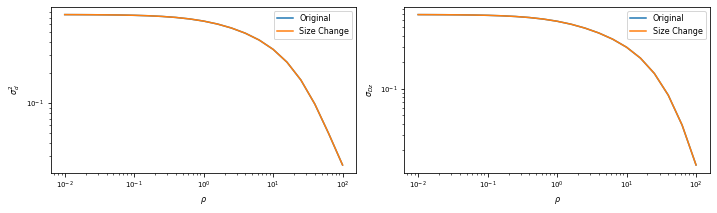

In [26]:
plot_comparison(sc_sliced_LD['Deme'][-1],sc_sc_sliced_LD['Deme'][-1])

##### 3. Bubble, inspired from Mende

[Split(parent='Ancestral', children=['Split_00', 'Split_01'], time=3448.0)]


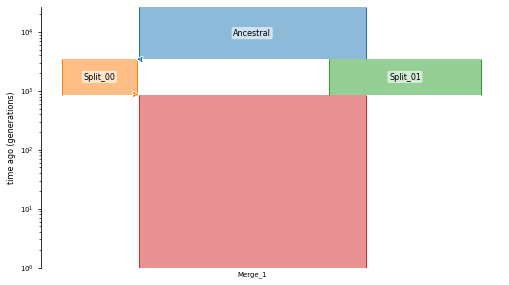

In [41]:
alpha1=[0.33,0.67]
alpha2=[0.819,0.181]
N=11.5e3

generation_time=29
time_period_merge_yrs =[1e6,25e3]
time_period_merge_gen = np.round(np.array(time_period_merge_yrs)/generation_time)
time_period_splits_yrs=[75e3]
time_period_splits_gen=np.round(np.array(time_period_splits_yrs)/generation_time)

bubble = model.cake_model(Ns=[N,N],splits=[2],alpha1=[alpha1],alpha2=[alpha2],time_period_merge=time_period_merge_gen,time_period_splits=time_period_splits_gen,migration_rate=0,time_units="generations",generation_time=1,plot=True)


[    0.           431.           861.           862.
  2155.          3447.          3448.         18965.37931034
 34481.75862069]
[11500.         11500.         11500.          5524.84567197
  5833.03541015  6196.16891106 11500.         11500.
 11500.        ]
size change from IICR
[11500  6196  5833  5524 11500] [3448. 3447. 2155.  862.    0.]
[{'start_size': 11500, 'end_time': 3448.0}, {'start_size': 6196, 'end_time': 3447.0}, {'start_size': 5833, 'end_time': 2155.0}, {'start_size': 5524, 'end_time': 862.0}, {'start_size': 11500, 'end_time': 0.0}]
added epochs
resolved
sizechange


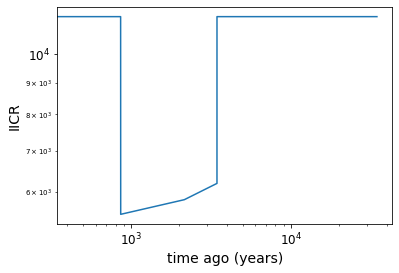

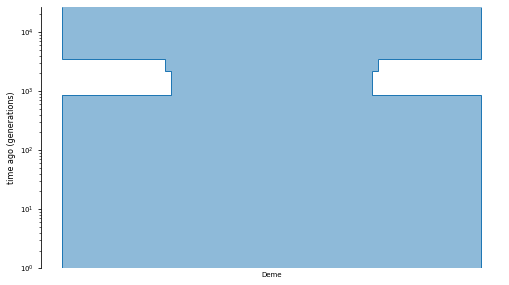

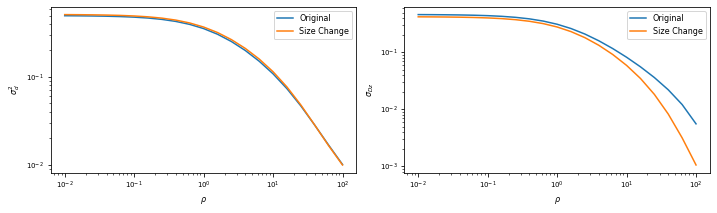

In [42]:
run_LD_analysis_from_model(bubble)

4. Bubble, symmetric alpha, no migration

[Split(parent='Ancestral', children=['Split_00', 'Split_01'], time=3448.0)]


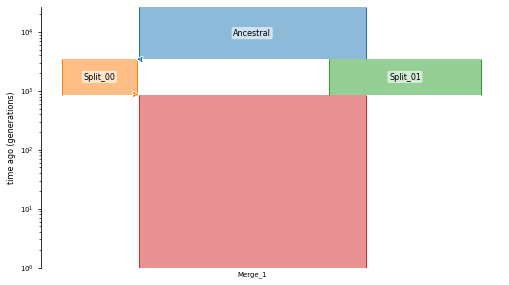

In [43]:
alpha1=[0.33,0.67]
alpha2=[0.33,0.67]
N=11.5e3

generation_time=29
time_period_merge_yrs =[1e6,25e3]
time_period_merge_gen = np.round(np.array(time_period_merge_yrs)/generation_time)
time_period_splits_yrs=[75e3]
time_period_splits_gen=np.round(np.array(time_period_splits_yrs)/generation_time)

bubble = model.cake_model(Ns=[N,N],splits=[2],alpha1=[alpha1],alpha2=[alpha2],time_period_merge=time_period_merge_gen,time_period_splits=time_period_splits_gen,migration_rate=0,time_units="generations",generation_time=1,plot=True,yaml_filename="Bubble_symmetric_alpha-Mende.yaml")


[    0.           431.           861.           862.
  2155.          3447.          3448.         18965.37931034
 34481.75862069]
[11500.         11500.         11500.         11500.
 12174.101824   12905.98557244 11500.         11500.
 11500.        ]
size change from IICR
[11499 12905 12174 11499 11500] [3448. 3447. 2155.  862.    0.]
[{'start_size': 11499, 'end_time': 3448.0}, {'start_size': 12905, 'end_time': 3447.0}, {'start_size': 12174, 'end_time': 2155.0}, {'start_size': 11499, 'end_time': 862.0}, {'start_size': 11500, 'end_time': 0.0}]
added epochs
resolved
sizechange


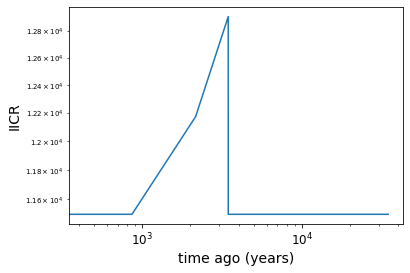

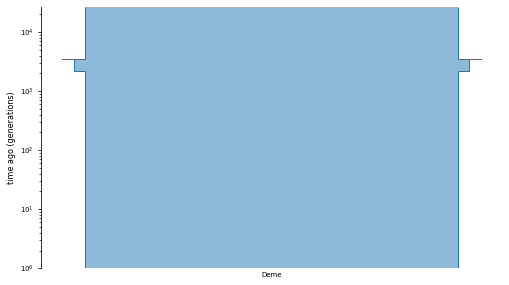

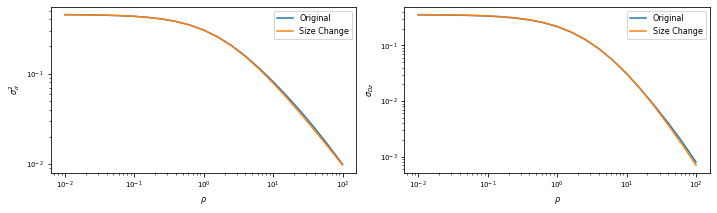

In [44]:
run_LD_analysis_from_model(bubble)

##### 5. Isolation with Migration model

<AxesSubplot:ylabel='time ago (generations)'>

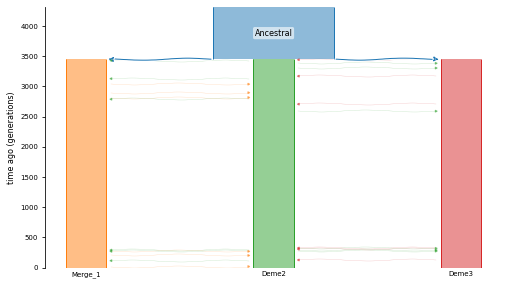

In [59]:
migration_rate1=1e-4
migration_rate2=1e-3 

# Check def of migration rate in Demes, N*u of order 1

m = demes.Builder(time_units="generations")

#  Add first Ancestor
m.add_deme("Ancestral",epochs=[dict(start_size=N, end_time=N*0.3)])

m.add_deme("Merge_1",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_deme("Deme2",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_deme("Deme3",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])

m.add_migration(demes = ["Merge_1","Deme2"], rate = migration_rate1, end_time=2500)
m.add_migration(demes = ["Deme3","Deme2"], rate = migration_rate1, end_time=2500)

m.add_migration(demes = ["Merge_1","Deme2"], rate = migration_rate2, start_time=time_period/6, end_time=1)
m.add_migration(demes = ["Deme3","Deme2"], rate = migration_rate2, start_time=time_period/6 ,end_time=1)

IM = m.resolve()
demesdraw.tubes(IM, log_time=False, num_lines_per_migration=3)

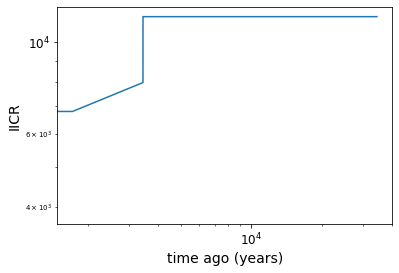

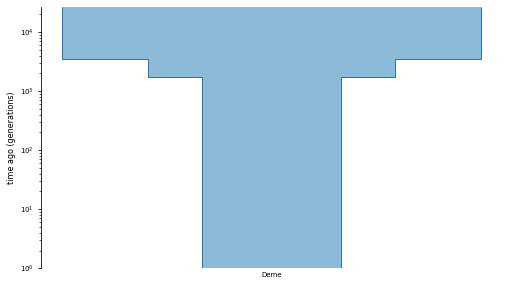

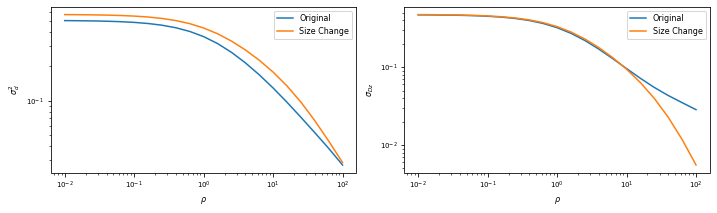

In [60]:
run_LD_analysis_from_model(IM)

In [ ]:
IM = model.cake_model(Ns=[N,N/3],splits=[3],proportions=[[1/3,1/3,1/3]],time_period_merge=[N,0],time_period_splits=[N],migration_rate=0.02,generation_time=1)

In [ ]:
# Sample times at epochs
T,times_dic = slice.sample_timepoints(IM)
# Compute LD 
im_sliced = slice.slice_timepoints(IM,time_points=[0])
im_sliced_LD = get_LD.get_LD_from_sliced_demes(im_sliced)

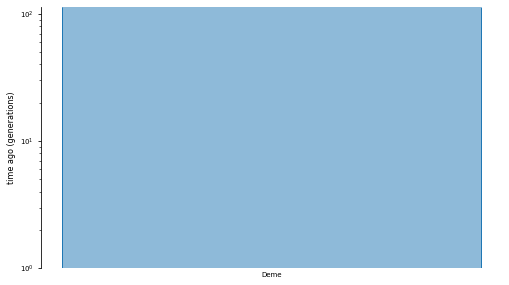

In [ ]:
# Get IIRC
im_R,im_iicr, _ = model.get_iicr(IM,pop="Deme1",T=T)
im_sc = model.size_change_from_iicr(im_iicr,times_dic['Deme1'],time_units="generations",plot=True)